<a href="https://colab.research.google.com/github/motkeg/Msc-Project/blob/master/fashion_cnn_tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fasion_MNIST  CNN model training on google TPU

---
first we import all the stuff of tensorflow etc


In [0]:
"""
this is an model that only use to detact fashion_mnist images
using tensorflow and keras
"""

import tensorflow as tf
 
from tensorflow.keras.layers import (MaxPool2D , Conv2D , Activation,
                                     Dropout , Flatten , 
                                     Dense , BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import fashion_mnist 
from tensorflow.keras.callbacks import TensorBoard , ModelCheckpoint
import os


#flags = tf.app.flags
#FLAGS = flags.FLAGS

USE_TPU = True #@param ["False", "True"] {type:"raw"}
LOG_DIR = "./output/"

if not os.path.exists(LOG_DIR+"/logs"):
    os.makedirs(LOG_DIR+"/logs")

## Define the class of ouer model

In [0]:


class cnn_fashion():

    # define tyhe train test and eval data
   

    def __init__(self):
        (self.x_train, self.y_train) ,(self.x_test, self.y_test)  = fashion_mnist.load_data()
        (self.x_valid,self.y_valid) = None, None
        self.model = Sequential()
        self.model_build()
        self.model.summary()
        # can't run tensorboard callback on TPU 
        self.tensorboard = TensorBoard(log_dir=LOG_DIR + "logs",
                          batch_size=128,
                            write_graph=True,
                            histogram_freq=3,
                            write_images=True,
                            write_grads=True)

        self.checkpointer = ModelCheckpoint(filepath=LOG_DIR + '/fashion-cnn-weights.best.hdf5', verbose = 1)   
        
                    
        print("x_train shape:", self.x_train.shape, "y_train shape:", self.y_train.shape)

    def __call__(self,train=True,predict=None):
        if train:
            self.prepare_data()
            self.Train()
        else :
            if predict is not None:
                self.Predict(predict)




    def prepare_data(self):
        # data Normalization
        self.x_train = self.x_train.astype('float32') / 255
        self.x_test = self.x_test.astype('float32') / 255
        # create a validation set fron the train data
        val_size  = int(len(self.x_train)*0.1)
        (self.x_valid,self.y_valid) = self.x_train[:val_size] , self.y_train[:val_size]
        #(self.x_tarin,self.y_train) = self.x_train[val_size:] , self.y_train[val_size:]

        # reshape the data to fit the model
        self.x_train = self.x_train.reshape(self.x_train.shape[0], 28, 28, 1)
        self.x_valid = self.x_valid.reshape(self.x_valid.shape[0], 28, 28, 1)
        self.x_test = self.x_test.reshape(self.x_test.shape[0], 28, 28, 1)

        # One-hot encode the labels
        self.y_train = tf.keras.utils.to_categorical(self.y_train, 10)
        self.y_valid = tf.keras.utils.to_categorical(self.y_valid, 10)
        self.y_test = tf.keras.utils.to_categorical(self.y_test, 10)


    def model_build(self):

        #-------------------------------
        # define the model and layers
        #------------------------------
        
        self.model.add(BatchNormalization(input_shape=(28,28,1)))
        self.model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
        self.model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))
        self.model.add(Dropout(0.25))

        self.model.add(BatchNormalization(input_shape=(28,28,1)))
        self.model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
        self.model.add(MaxPool2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))

        self.model.add(BatchNormalization(input_shape=(28,28,1)))
        self.model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
        self.model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))
        self.model.add(Dropout(0.25))

        self.model.add(Flatten())
        self.model.add(Dense(256))
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(10))
        self.model.add(Activation('softmax'))

        if USE_TPU:
           
            strategy = tf.contrib.tpu.TPUDistributionStrategy(
                        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']))
            self.model = tf.contrib.tpu.keras_to_tpu_model(self.model, strategy=strategy)

        #-------------------------------
        # compile the model 
        #-----------------------------
        self.model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])


    def Train(self):
        #-------------------------------
        # fit (train) the model 
        #-----------------------------
        self.model.fit(self.x_train, self.y_train,
                    batch_size=128,
                    epochs=50,
                    validation_data=(self.x_test,self.y_test),
                    callbacks=[self.checkpointer],
                    shuffle=True)

        # Evaluate the model on test set
        score = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        # Print test accuracy
        print('\n', 'Test accuracy:', score[1])  

    def Predict(self,predict):
        pass
        #TODO: complate this phase     
        
        
        


# Run the train phase

In [0]:
model =  cnn_fashion()
model()

# check the results (make a prediction based on our saved weights)

you can run this as a single cell witout run all the notebook before.  
***validate that you have the "fashion-cnn-weights.best.hdf5" file ***

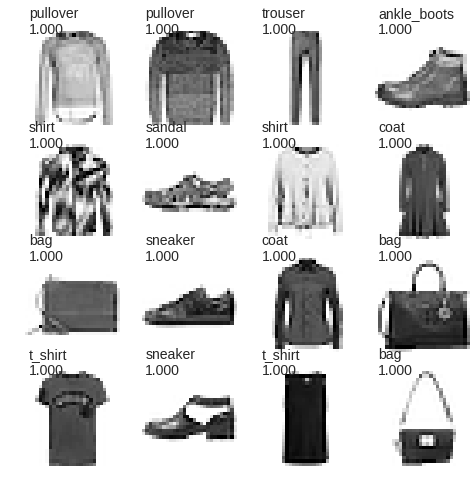

In [11]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt 

(x_train, y_train) ,(x_test, y_test)  = fashion_mnist.load_data()
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = plt.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  plt.gcf().set_size_inches(8, 8)  
  
  
  
# you can run this as a single cell

new_model = load_model("./output/fashion-cnn-weights.best.hdf5")
plot_predictions(np.squeeze(x_test[16:32]), 
                 new_model.predict(x_test[16:32]))

